In [28]:
import netCDF4 as nc
import numpy as np
import pylab as plt
import xarray as xr

maindir = '/projects/awaken/j3lee/run_amrw/stable/20180610-5m/'

In [29]:
stat_dir = 'done'

# when using xarray multifile dataset, have to grab each group of the nc files individually
xtime = xr.open_mfdataset(maindir+stat_dir+'/abl_statistics*.nc', concat_dim=['num_time_steps'], combine='nested')

xprof = xr.open_mfdataset(maindir+stat_dir+'/abl_statistics*.nc', group='mean_profiles', 
                          concat_dim=['num_time_steps'], combine='nested')

In [36]:
xprof

<xarray.Dataset>
Dimensions:       (nlevels: 600, num_time_steps: 50)
Dimensions without coordinates: nlevels, num_time_steps
Data variables: (12/26)
    h             (num_time_steps, nlevels) float64 dask.array<concatenate, s...
    u             (num_time_steps, nlevels) float64 dask.array<concatenate, s...
    v             (num_time_steps, nlevels) float64 dask.array<concatenate, s...
    w             (num_time_steps, nlevels) float64 dask.array<concatenate, s...
    hvelmag       (num_time_steps, nlevels) float64 dask.array<concatenate, s...
    theta         (num_time_steps, nlevels) float64 dask.array<concatenate, s...
    ...            ...
    v'theta'_sfs  (num_time_steps, nlevels) float64 dask.array<concatenate, s...
    w'theta'_sfs  (num_time_steps, nlevels) float64 dask.array<concatenate, s...
    u'v'_sfs      (num_time_steps, nlevels) float64 dask.array<concatenate, s...
    u'w'_sfs      (num_time_steps, nlevels) float64 dask.array<concatenate, s...
    v'w'_sfs      (num_time_steps, nlevels) float64 dask.array<concatenate, s...
    k_sgs         (num_time_steps, nlevels) float64 dask.array<concatenate, s...

In [43]:
# the forcing file used for the simulation 
forcing = nc.Dataset(maindir+'forcing_20180610_v5m3z6h.nc')
print(forcing.variables.keys())

dict_keys(['heights', 'times', 'wrf_momentum_u', 'wrf_momentum_v', 'wrf_temperature', 'wrf_tflux'])


In [59]:
sim_height = xprof['h'].values#[0,:] # uncomment the index bracket if you 
#actually have multiple files, it will cause an error if there is a single file
sim_time = xtime['time'].values
print(sim_time)

forcing_height = forcing['heights'][:]
forcing_time = forcing['times'][:]
n_fh = len(forcing_height)
n_ft = len(forcing_time)
# or n_fh = forcing.dimensions['nheight'].size

forcing_momu = np.reshape(forcing['wrf_momentum_u'][:], (n_ft, n_fh))
forcing_momv = np.reshape(forcing['wrf_momentum_v'][:], (n_ft, n_fh))
forcing_temp = np.reshape(forcing['wrf_temperature'][:], (n_ft, n_fh))

[ 150.  300.  450.  600.  750.  900. 1050. 1200. 1350. 1500. 1650. 1800.
 1950. 2100. 2250. 2400. 2550. 2700. 2850. 3000. 3150. 3300. 3450. 3600.
 3750. 3900. 4050. 4200. 4350. 4500. 4650. 4800. 4950. 5100. 5250. 5400.
 5550. 5700. 5850. 6000. 6150. 6300. 6450. 6600. 6750. 6900. 7050. 7200.
 7350. 7500.]


In [72]:
xprof['theta']

<xarray.DataArray 'theta' (num_time_steps: 50, nlevels: 600)>
dask.array<concatenate, shape=(50, 600), dtype=float64, chunksize=(36, 600), chunktype=numpy.ndarray>
Dimensions without coordinates: num_time_steps, nlevels

(50, 600)
(50, 600)


ValueError: x and y must have same first dimension, but have shapes (600,) and (50, 600)

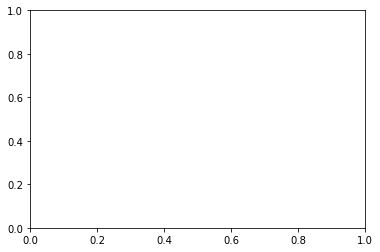

In [68]:
print(np.shape(xprof['theta'].values))
print(np.shape(hd))

plt.plot(xprof['theta'].values[0,:], sim_height, label='18 UTC, sim')
# plt.plot(xprof['theta'].values[-1,:],hd, label='23 UTC, sim')

plt.plot(forcing_temp[0,:], forcing_height, linestyle='dashed', color='C0', label='18 UTC, obs')
# plt.plot(wrfvar[-1,:],hf,linestyle='dashed', color='C1', label='23 UTC, obs')
plt.xlabel('Potential Temperature [K]')
plt.ylabel('Height [m]')
plt.legend()
plt.grid(True)

Text(0.5, 1.0, 'Forcing')

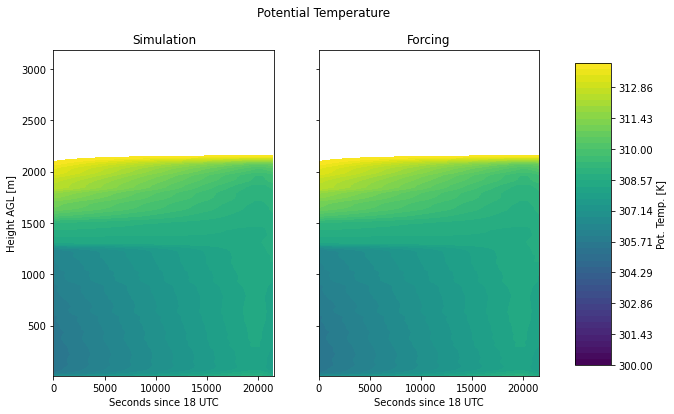

In [23]:
wrfvar=np.reshape(forcing.variables['wrf_temperature'][:], (ntf,nhf))

fig, ax = plt.subplots(figsize=(10,6),ncols=2,sharey=True,sharex=True)
im=ax[0].contourf(td,hd, xprof['theta'].values.T, levels=np.linspace(300,314))
ax[1].contourf(tf,hf, wrfvar.T, levels=np.linspace(300,314))

plt.xlim(0,21600)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Pot. Temp. [K]')
plt.suptitle('Potential Temperature')

ax[0].set_xlabel('Seconds since 18 UTC')
ax[1].set_xlabel('Seconds since 18 UTC')
ax[0].set_ylabel('Height AGL [m]')

ax[0].set_title('Simulation')
ax[1].set_title('Forcing')

Text(0.5, 1.0, 'Forcing')

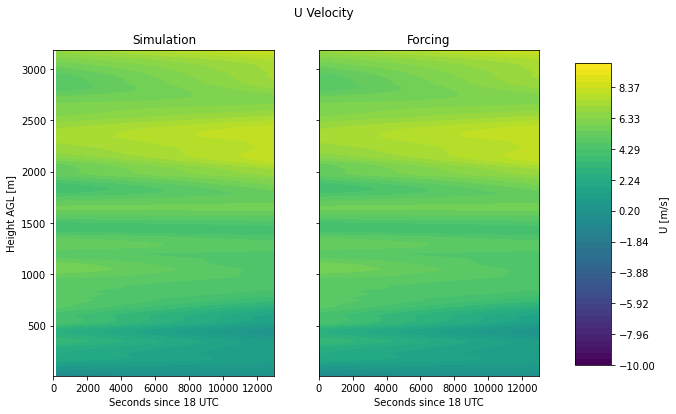

In [24]:
wrfvar=np.reshape(forcing.variables['wrf_momentum_u'][:], (ntf,nhf))

fig, ax = plt.subplots(figsize=(10,6),ncols=2,sharey=True,sharex=True)
im=ax[0].contourf(td,hd, xprof['u'].values.T, levels=np.linspace(-10,10))
ax[1].contourf(tf,hf, wrfvar.T, levels=np.linspace(-10,10))

plt.xlim(0,13000)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='U [m/s]')
plt.suptitle('U Velocity')

ax[0].set_xlabel('Seconds since 18 UTC')
ax[1].set_xlabel('Seconds since 18 UTC')
ax[0].set_ylabel('Height AGL [m]')

ax[0].set_title('Simulation')
ax[1].set_title('Forcing')

Text(0.5, 1.0, 'Forcing')

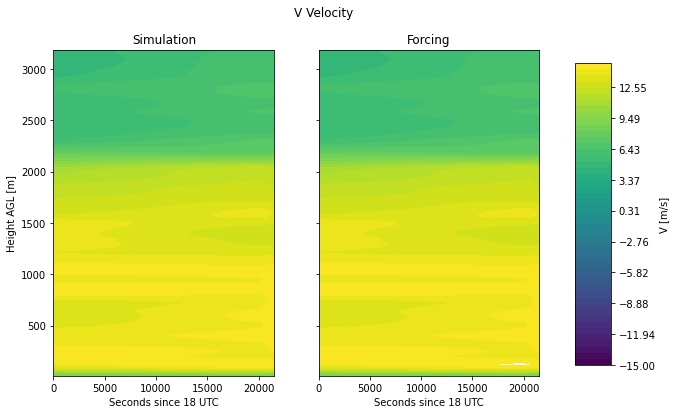

In [25]:
wrfvar=np.reshape(forcing.variables['wrf_momentum_v'][:], (ntf,nhf))

fig, ax = plt.subplots(figsize=(10,6),ncols=2,sharey=True,sharex=True)
im=ax[0].contourf(td,hd, xprof['v'].values.T, levels=np.linspace(-15,15))
ax[1].contourf(tf,hf, wrfvar.T, levels=np.linspace(-15,15))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='V [m/s]')
plt.suptitle('V Velocity')

ax[0].set_xlabel('Seconds since 18 UTC')
ax[1].set_xlabel('Seconds since 18 UTC')
ax[0].set_ylabel('Height AGL [m]')

ax[0].set_title('Simulation')
ax[1].set_title('Forcing')

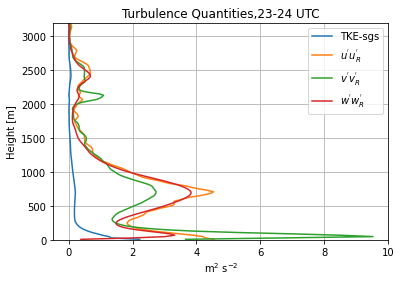

In [26]:
plt.plot(np.mean(xprof['k_sgs'].values[-24:-1,:],axis=0), hd, color='C0', label='TKE-sgs')
plt.plot(np.mean(xprof['u\'u\'_r'][-24:-1,:],axis=0), hd, color='C1', label=r"$u^{'}u^{'}_{R}$")
plt.plot(np.mean(xprof['v\'v\'_r'][-24:-1,:],axis=0), hd, color='C2',label=r"$v^{'}v^{'}_{R}$")
plt.plot(np.mean(xprof['w\'w\'_r'][-24:-1,:], axis=0),hd, color='C3',label=r"$w^{'}w^{'}_{R}$")
plt.ylim(0,3200)
# plt.xlim(-0.001,0.45)
plt.grid(True)
plt.title('Turbulence Quantities,23-24 UTC')
plt.ylabel('Height [m]')
plt.xlabel('m$^2$ s$^{-2}$')
plt.legend()

In [10]:
#wstat = nc.Dataset('/projects/awaken/ckaul/wrfForcing/20170628/225451/sgpdlprofwstats4newsC1.c1.20170629.000000.nc')
wstat = nc.Dataset('/projects/awaken/ckaul/wrfForcing/20170619/sgpdlprofwstats4newsC1.c1.20170619.000000.nc')
print(wstat.variables.keys())
wvar = wstat.variables['w_variance'][:,:]
snr = wstat.variables['snr'][:,:]
noise = wstat.variables['noise'][:,:]

wvar = np.ma.masked_where(snr <0.008, wvar)
# wvar = np.ma.masked_where(noise > 1, wvar) --this masks almost everything, need to ask Rob about it

odict_keys(['base_time', 'time_offset', 'time', 'time_bounds', 'height', 'snr', 'snr_25', 'snr_75', 'w', 'w_25', 'w_75', 'noise', 'w_variance', 'w_skewness', 'w_kurtosis', 'dl_cbh', 'dl_cbh_25', 'dl_cbh_75', 'dl_cbh_zmax', 'dl_cloud_frequency', 'cbw', 'cbw_25', 'cbw_75', 'cbw_up_fraction', 'nshots', 'ngate_samples', 'averaging_time', 'snr_threshold', 'sample_frequency', 'wavelength', 'ceil_cbh', 'ceil_cbh_25', 'ceil_cbh_75', 'ceil_cbh_zmax', 'ceil_cloud_frequency', 'ceil_lat', 'ceil_lon', 'ceil_alt', 'ecor_temp', 'ecor_h2o', 'ecor_tke', 'ecor_ustar', 'ecor_w_var', 'ecor_w_skew', 'ecor_w_kurt', 'ecor_wt', 'ecor_wq', 'ecor_lat', 'ecor_lon', 'ecor_alt', 'met_spr_mean', 'met_spr_min', 'met_spr_max', 'met_lat', 'met_lon', 'met_alt', 'lat', 'lon', 'alt'])


Text(0.5, 1.0, 'Doppler Lidar')

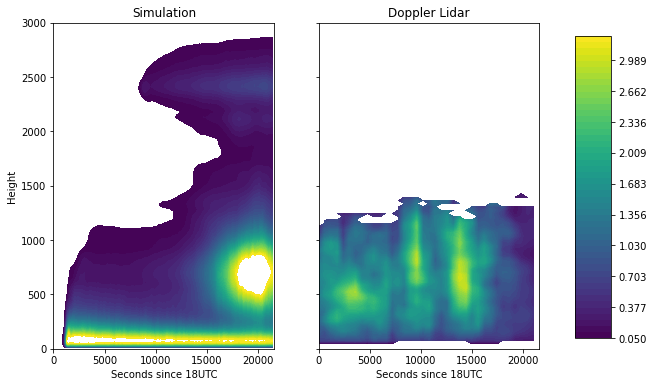

In [27]:


fig, ax = plt.subplots(figsize=(10,6),ncols=2,sharey=True,sharex=True)
im=ax[0].contourf(td,hd, xprof['w\'w\'_r'][:,:].T, levels=np.linspace(0.05,3.25))
ax[1].contourf(wstat.variables['time'][:]-18*3600, wstat.variables['height'][:], 
               wvar[:,:].T, levels=np.linspace(0.05,3.25))

plt.xlim(0,21600)
plt.ylim(0,3000)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
ax[0].set_ylabel('Height')
ax[0].set_xlabel('Seconds since 18UTC')
ax[1].set_xlabel('Seconds since 18UTC')
ax[0].set_title('Simulation')
ax[1].set_title('Doppler Lidar')

Text(0.5, 0, 'w variance [m$^2$ s$^{-2}$]')

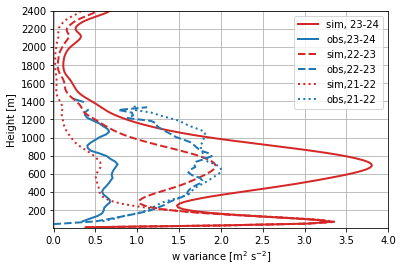

In [28]:
#
plt.plot(np.mean(xprof['w\'w\'_r'][-24:,:],axis=0), 
         hd, color='C3',label='sim, 23-24',linewidth=2)

plt.plot(np.ma.mean(wvar[-6:,:],axis=0), wstat.variables['height'][:], 
         color='C0', label='obs,23-24',linewidth=2)

plt.plot(np.mean(xprof['w\'w\'_r'][-48:-24,:],axis=0), hd, 
         color='C3',linestyle='dashed',label='sim,22-23',linewidth=2)

plt.plot(np.ma.mean(wvar[-12:-6,:],axis=0), wstat.variables['height'][:],
         color='C0',linestyle='dashed',label='obs,22-23',linewidth=2)

plt.plot(np.mean(xprof['w\'w\'_r'][-72:-48,:],axis=0), hd, color='C3',
         linestyle='dotted', label='sim,21-22',linewidth=2)
plt.plot(np.ma.mean(wvar[-18:-12,:],axis=0), wstat.variables['height'][:], 
         color='C0',linestyle='dotted',label='obs,21-22',linewidth=2)


plt.ylim(0,2400)
plt.xlim(-0.001,4)
plt.yticks(np.arange(200,2600,200))
plt.grid(True)
plt.legend()
plt.ylabel(r'Height [m]')
plt.xlabel(r'w variance [m$^2$ s$^{-2}$]')

Text(0, 0.5, 'Height [m]')

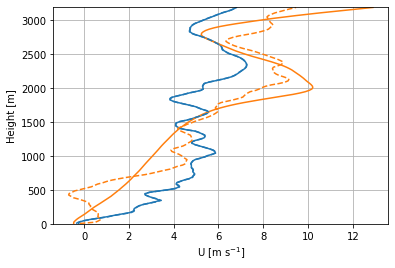

In [13]:

plt.plot(xprof['u'].values[0,:],hd, label='18 UTC,sim', color='C0')
plt.plot(xprof['u'].values[-1,:],hd, label='23 UTC,sim', color='C1')


wrfvar=np.reshape(forcing.variables['wrf_momentum_u'][:], (ntf,nhf))
plt.plot(wrfvar[0,:],hf, linestyle='dashed', color='C0', label='18 UTC obs')
plt.plot(wrfvar[-1,:],hf,linestyle='dashed', color='C1',label='23 UTC obs')

plt.ylim(0,3200)
# plt.xlim(-0.001,0.45)
plt.grid(True)
plt.xlabel(r'U [m s$^{-1}$]')
plt.ylabel(r'Height [m]')

Text(0, 0.5, 'Height [m]')

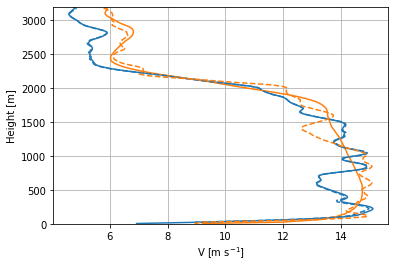

In [14]:

plt.plot(xprof['v'].values[0,:],hd, label='18 UTC,sim', color='C0')
plt.plot(xprof['v'].values[-1,:],hd, label='23 UTC,sim', color='C1')


wrfvar=np.reshape(forcing.variables['wrf_momentum_v'][:], (ntf,nhf))
plt.plot(wrfvar[0,:],hf, linestyle='dashed', color='C0', label='18 UTC obs')
plt.plot(wrfvar[-1,:],hf,linestyle='dashed', color='C1',label='23 UTC obs')

plt.ylim(0,3200)
# plt.xlim(-0.001,0.45)
plt.grid(True)
plt.xlabel(r'V [m s$^{-1}$]')
plt.ylabel(r'Height [m]')